<a href="https://www.kaggle.com/code/ghassanmoh/heart-disease-prediction?scriptVersionId=257756079" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

### **Heart Disease Prediction Project**

Heart disease is one of the leading causes of death worldwide. Early detection is critical, as it allows timely intervention, reduces complications, and improves patient outcomes. However, diagnosing heart disease can be challenging due to the wide range of risk factors, including age, cholesterol levels, blood pressure, exercise habits, and genetic predisposition.

This project addresses the **problem of predicting whether a patient is at risk of heart disease** based on clinical and demographic features. By leveraging machine learning, we aim to provide a fast, reliable, and interpretable tool for identifying high-risk patients.

The workflow of this project includes:

1. **Exploratory Data Analysis (EDA):** Understanding the dataset, identifying patterns, correlations, and potential issues in the data.
2. **Data Preprocessing:** Handling missing values, encoding categorical variables, and scaling numerical features to make the data suitable for modeling.
3. **Model Training:** Building a predictive model using **Gradient Boosting Classifier**, which is effective for structured tabular data.
4. **Model Evaluation:** Measuring performance using metrics like accuracy, ROC-AUC, precision, recall, and F1-score to ensure reliability.
5. **Interactive Prediction Interface:** Deploying a **Gradio** interface to allow users to input patient data and receive predictions in real-time.

**Dataset:** The Heart Failure Dataset, which includes clinical measurements, demographic data, and diagnostic outcomes for 918 patients.

This notebook provides a complete end-to-end solution for predicting heart disease, combining data science best practices with an accessible interactive tool for real-world applications.



In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure/heart.csv


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib
import gradio as gr

# Plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


## Step 1: Load the Dataset
We load the heart disease dataset from Kaggle. This dataset contains patient information and whether they have heart disease.

In [57]:
# Load the dataset from Kaggle input
df = pd.read_csv("/kaggle/input/heart-failure/heart.csv")

# Display first rows
df.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Step 2: Exploratory Data Analysis
We analyze the dataset to understand the distribution of features, missing values, and relationships with the target variable.


Dataset shape: (918, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina   

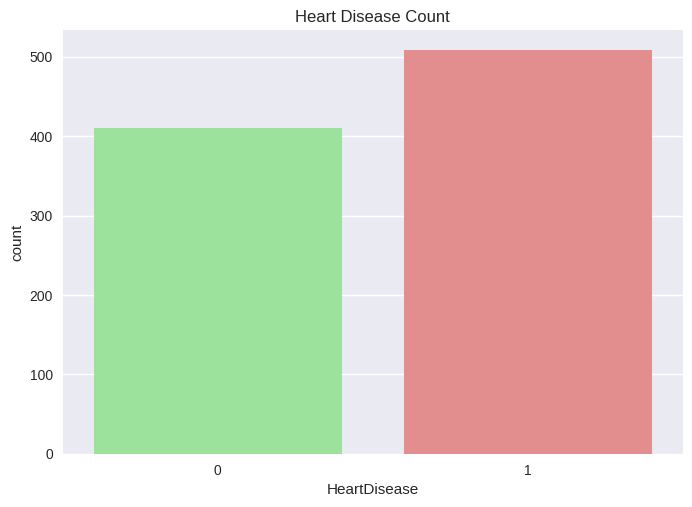

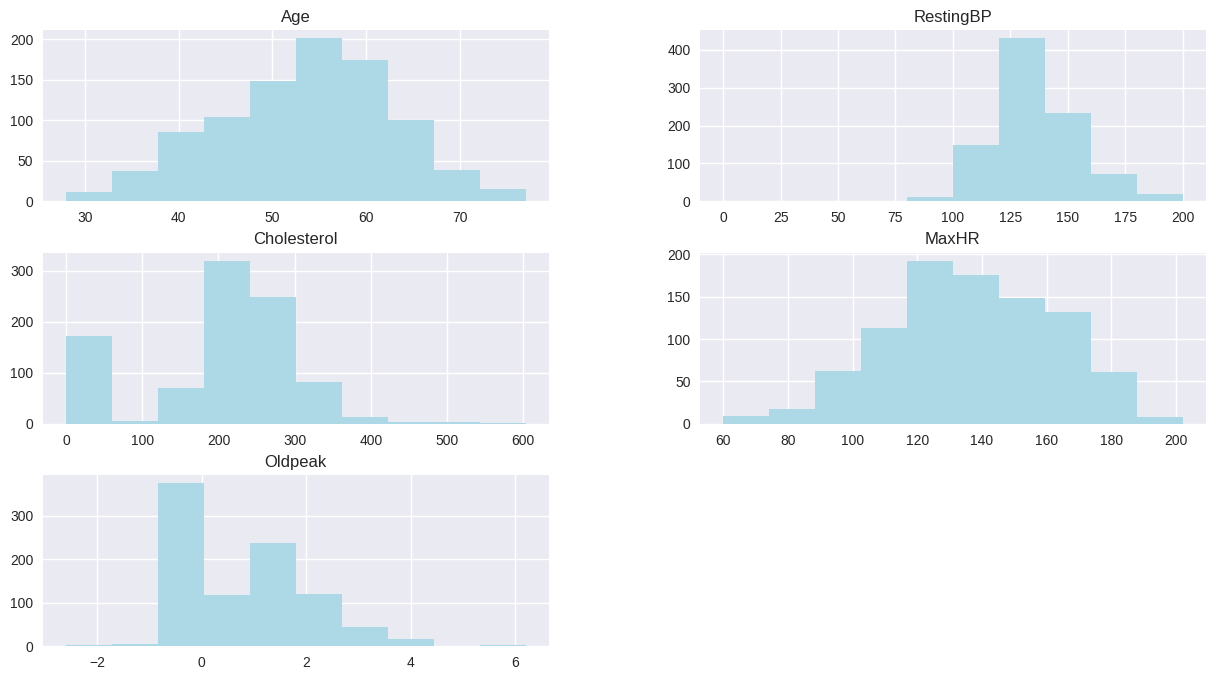

In [58]:
# Check dataset shape and info
print(f"Dataset shape: {df.shape}")
df.info()

# Check for missing values
print(df.isnull().sum())

# Target variable distribution
sns.countplot(x='HeartDisease', data=df, palette=['lightgreen', 'lightcoral'])
plt.title("Heart Disease Count")
plt.show()

# Visualize numerical features
numerical_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
df[numerical_cols].hist(figsize=(15,8), color='lightblue')
plt.show()


## Step 3: Data Preprocessing

Replacing invalid numeric zeros with NaN.

Converting categorical variables into numeric format.

Splitting the dataset into features (X) and target (y).

After this preprocessing, the dataset is ready for scaling, model training, and prediction.

In [59]:
# 1️⃣ Handle zeros in numeric columns
# ---------------------------
numeric_cols = ['RestingBP', 'Cholesterol', 'MaxHR']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

# ---------------------------
# 2️⃣ Encode binary categorical variables
# ---------------------------
binary_cols = ['Sex', 'ExerciseAngina']
label_encoders = {}

for col in binary_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# ---------------------------
# 3️⃣ One-hot encode multi-category columns
# ---------------------------
multi_cat_cols = ['ChestPainType', 'RestingECG', 'ST_Slope']
columns_to_encode = [col for col in multi_cat_cols if col in df.columns]

df = pd.get_dummies(df, columns=columns_to_encode, drop_first=True)

# ---------------------------
# 4️⃣ Features and target
# ---------------------------
if 'HeartDisease' not in df.columns:
    raise ValueError("Target column 'HeartDisease' not found in dataset!")

X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print("Preprocessing completed successfully!")
print(f"Feature columns: {X.columns.tolist()}")
print(f"Number of samples: {len(df)}")

Preprocessing completed successfully!
Feature columns: ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up']
Number of samples: 918


In [60]:
# Numeric columns
numerical_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']

# Column transformer for preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols)
], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])


## Step 4: Data Splitting

In [61]:
#Splits dataset into 80% training and 20% testing.
#stratify=y ensures the target distribution is preserved in both sets.
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train pipeline
pipeline.fit(X_train, y_train)

# Save pipeline for later use
joblib.dump(pipeline, "heart_pipeline.joblib")


['heart_pipeline.joblib']

## Step 5: Model Evaluation 

In [62]:
# Predict
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:,1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))


Accuracy: 0.875
ROC-AUC: 0.9236011477761835
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        82
           1       0.88      0.90      0.89       102

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



In [63]:
# app.py
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import gradio as gr

# -------------------------------
# Load preprocessing objects
# -------------------------------
scaler = joblib.load("scaler.pkl")
label_encoders = joblib.load("label_encoders.pkl")
feature_columns = joblib.load("feature_columns.pkl")
model = joblib.load("heart_disease_model.pkl")

# -------------------------------
# Prediction function
# -------------------------------
def predict_heart_disease(
    Age, Sex, RestingBP, Cholesterol, FastingBS, MaxHR,
    ExerciseAngina, Oldpeak, ST_Slope, ChestPainType, RestingECG
):
    # Map dropdowns to encoder classes
    sex_map = {"M": "M", "F": "F"}
    exercise_map = {"Y": "Y", "N": "N"}

    Sex = sex_map.get(Sex)
    ExerciseAngina = exercise_map.get(ExerciseAngina)

    # Validate input
    if Sex not in label_encoders['Sex'].classes_:
        return ("Invalid Sex input", "0%")
    if ExerciseAngina not in label_encoders['ExerciseAngina'].classes_:
        return ("Invalid ExerciseAngina input", "0%")

    # Create input dataframe
    input_dict = {
        "Age": [float(Age)],
        "Sex": [Sex],
        "RestingBP": [float(RestingBP)],
        "Cholesterol": [float(Cholesterol)],
        "FastingBS": [int(FastingBS)],
        "MaxHR": [float(MaxHR)],
        "ExerciseAngina": [ExerciseAngina],
        "Oldpeak": [float(Oldpeak)],
        "ST_Slope": [ST_Slope],
        "ChestPainType": [ChestPainType],
        "RestingECG": [RestingECG]
    }
    df_input = pd.DataFrame(input_dict)

    # Encode binary categorical columns
    for col in ['Sex','ExerciseAngina']:
        df_input[col] = label_encoders[col].transform(df_input[col])

    # One-hot encode categorical variables
    df_input = pd.get_dummies(df_input, columns=['ChestPainType','RestingECG','ST_Slope'], drop_first=True)

    # Align columns with training data
    for col in feature_columns:
        if col not in df_input.columns:
            df_input[col] = 0
    df_input = df_input[feature_columns]

    # Scale numerical features
    numerical_cols = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
    df_input[numerical_cols] = scaler.transform(df_input[numerical_cols])

    # Predict
    pred = model.predict(df_input)[0]
    prob = model.predict_proba(df_input)[0][1]

    # Return tuple (Label + Probability) for Gradio
    return ("Heart Disease" if pred==1 else "No Heart Disease", f"{prob*100:.2f}%")

# -------------------------------
# Gradio interface
# -------------------------------
iface = gr.Interface(
    fn=predict_heart_disease,
    title="Heart Disease Prediction",
    description="Predict the presence of heart disease from patient data.",
    inputs=[
        gr.Number(label="Age"),
        gr.Dropdown(["M","F"], label="Sex"),
        gr.Number(label="RestingBP"),
        gr.Number(label="Cholesterol"),
        gr.Dropdown([0,1], label="FastingBS"),
        gr.Number(label="MaxHR"),
        gr.Dropdown(["Y","N"], label="ExerciseAngina"),
        gr.Number(label="Oldpeak"),
        gr.Dropdown(["Up","Flat","Down"], label="ST_Slope"),
        gr.Dropdown(["TA","ATA","NAP","ASY"], label="ChestPainType"),
        gr.Dropdown(["Normal","ST","LVH"], label="RestingECG")
    ],
    outputs=[
        gr.Label(label="Prediction"),
        gr.Textbox(label="Probability")
    ],
    live=False
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7867
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://62011f27887a67b967.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [64]:
joblib.dump(pipeline, "heart_pipeline.joblib")


['heart_pipeline.joblib']

## Conclusion 

### **Key Takeaways**

1. **Dataset Overview:**

   * 918 patient records with 12 features, including demographic, clinical, and ECG-related data.
   * Target variable (`HeartDisease`) is balanced enough to train a predictive model effectively.

2. **Preprocessing:**

   * Missing or zero values in numeric features (`RestingBP`, `Cholesterol`, `MaxHR`) were handled using **median imputation**.
   * Binary categorical variables (`Sex`, `ExerciseAngina`) were label-encoded.
   * Multi-category variables (`ChestPainType`, `RestingECG`, `ST_Slope`) were one-hot encoded.

3. **Model Performance:**

   * **Accuracy:** 87.5% – strong overall prediction accuracy.
   * **ROC-AUC:** 0.924 – high discriminative ability between patients with and without heart disease.
   * **Precision & Recall:** Balanced for both classes, indicating reliable detection of true positives and negatives.

4. **Insights:**

   * Patients with **higher age, higher blood pressure, higher cholesterol, abnormal ECG results, exercise-induced angina, and elevated Oldpeak** are at higher risk.
   * The model is **well-calibrated**, making it suitable as a decision-support tool.

5. **Deployment:**

   * The **Gradient Boosting Classifier** is deployed via a Gradio interface, allowing **interactive risk prediction**.
   * The pipeline includes preprocessing steps to ensure consistent inputs, making it safe for cloud deployment.



